In [57]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import os
import json

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

import logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao']
ACTIVITIES = ['sit','walk','upstair']
CHUNK_SIZE = 2.375  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
NUM_CLASSES = 3

In [58]:
# Define constants
OVERLAP = 0.5  # Fix for previous NameError

# Define feature extraction function
def extract_features(chunk):
    """Extract features from a chunked acceleration segment with selected statistics."""
    feature_vector = []
    
    for axis in ['x', 'y', 'z']:
        data_series = pd.Series(chunk[axis])
        # Apply smoothing
        smoothed_data = data_series.rolling(window=5, min_periods=1).mean()
        feature_vector.extend([
            smoothed_data.mean(),                  # Mean
            smoothed_data.median(),                # Median
            smoothed_data.std(),                   # Standard deviation
            smoothed_data.var(),                   # Variance
            smoothed_data.min(),                   # Minimum
            smoothed_data.max(),                   # Maximum
        ])
    return feature_vector

In [59]:
# Filter data 
def fetch_data_for_stephen(collection_name, activities, time_start=500, time_end=6000):
    data, docs = [], []
    person_name = "Stephen"
    
    for activity in activities:
        for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
            record = recording.to_dict()
            if 'acceleration' not in record:
                continue

            docs.append(record)
            df = pd.DataFrame(record['acceleration'])
            
            if 'time' in df.columns:
                filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                data.append(filtered_df)
            else:
                raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch data
training_data_raw, training_docs = fetch_data_for_stephen("training", ACTIVITIES)
testing_data_raw, testing_docs = fetch_data_for_stephen("testing", ACTIVITIES)

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
from tabulate import tabulate

def chunk_data_with_overlap(data_raw, docs, chunk_size, activities, sampling_rate, overlap):
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)
    step = int(chunk_samples * (1 - overlap))  # compute step size based on overlap

    for i in range(len(data_raw)):
        total_samples = len(data_raw[i]['x'])
        for start in range(0, total_samples - chunk_samples + 1, step):
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])  # Shape: (chunk_samples, 3)
            labels.append(label)

    return data, labels, activity_distribution


# Combine raw data and docs
all_data_raw = training_data_raw + testing_data_raw
all_docs = training_docs + testing_docs

# Chunk all data
all_data, all_labels, all_distribution = chunk_data(all_data_raw, all_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

# Perform stratified train-test split
indices = np.arange(len(all_data))
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=all_labels
)

# Split data and labels
training_data = [all_data[i] for i in train_indices]
training_labels = [all_labels[i] for i in train_indices]
testing_data = [all_data[i] for i in test_indices]
testing_labels = [all_labels[i] for i in test_indices]

# Compute activity distributions
training_distribution = np.bincount(training_labels, minlength=len(ACTIVITIES))
testing_distribution = np.bincount(testing_labels, minlength=len(ACTIVITIES))



In [61]:
from tabulate import tabulate #for table formatting

#Calculate the number of training and testing samples
num_training_samples = len(training_data_raw)
num_testing_samples = len(testing_data_raw)


#table
summary_table = [["training", num_training_samples], ["testing", num_testing_samples]]

#print
print("dataset summary:")
print(tabulate(summary_table, headers = ["Dataset", "number of chunks"], tablefmt="pretty"))

print("Training Activities Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}: {int(training_distribution[i])} chunks")

print("\nTesting Activity Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}:{int(testing_distribution[i])} chunks")
print(len(training_data_raw))
print(len(testing_data_raw))
print(np.array(training_data).shape)
print(len(training_data_raw))
print(len(testing_data_raw))

dataset summary:
+----------+------------------+
| Dataset  | number of chunks |
+----------+------------------+
| training |        6         |
| testing  |        6         |
+----------+------------------+
Training Activities Count
sit: 7 chunks
walk: 6 chunks
upstair: 6 chunks

Testing Activity Count
sit:1 chunks
walk:2 chunks
upstair:2 chunks
6
6
(19, 3, 237)
6
6


In [62]:
# Extract features using chunk_data_with_overlap
X_train, y_train, train_distribution = chunk_data_with_overlap(
    training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP
)
X_test, y_test, test_distribution = chunk_data_with_overlap(
    testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP
)

# Combine train and test for cross-validation
X_all = np.concatenate([X_train, X_test], axis=0)  # Shape: (num_chunks, 3, chunk_samples)
y_all = np.concatenate([y_train, y_test], axis=0)

# Reshape to 2D: (num_chunks, 3 * chunk_samples)
n_chunks, n_axes, n_samples = X_all.shape
X_all_reshaped = X_all.reshape(n_chunks, n_axes * n_samples)

# Normalize the features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_reshaped)

# Convert to torch tensors
X_all = torch.tensor(X_all_scaled, dtype=torch.float32)  # Shape: (n_samples, n_features)
y_all = torch.tensor(y_all, dtype=torch.long)

print("Training Activity Distribution:", train_distribution)
print("Testing Activity Distribution:", test_distribution)


Training Activity Distribution: [6. 6. 6.]
Testing Activity Distribution: [6. 6. 6.]


In [63]:
''' class OptimizedLSTMModel(nn.Module):
    def __init__(self, num_classes, input_channels, seq_length, hidden_size=128, num_layers=2):
        super(OptimizedLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer expects input of shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(input_channels, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer to output predictions
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM requires a hidden state and cell state to be initialized
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Use the output of the last timestep for classification
        out = out[:, -1, :]  # Take the last hidden state
        out = self.dropout(out)
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out
'''

' class OptimizedLSTMModel(nn.Module):\n    def __init__(self, num_classes, input_channels, seq_length, hidden_size=128, num_layers=2):\n        super(OptimizedLSTMModel, self).__init__()\n        self.seq_length = seq_length\n        self.hidden_size = hidden_size\n        self.num_layers = num_layers\n        \n        # LSTM layer expects input of shape (batch_size, seq_length, input_size)\n        self.lstm = nn.LSTM(input_channels, hidden_size, num_layers, batch_first=True)\n        \n        # Fully connected layer to output predictions\n        self.fc = nn.Linear(hidden_size, num_classes)\n        \n        # Dropout layer for regularization\n        self.dropout = nn.Dropout(0.3)\n\n    def forward(self, x):\n        # LSTM requires a hidden state and cell state to be initialized\n        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)\n        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)\n\n        # Pass through LSTM

In [64]:
# Model for extracted features (MLP)
class FeatureModel(nn.Module):
    def __init__(self, num_classes, input_features=18):
        super(FeatureModel, self).__init__()
        self.fc1 = nn.Linear(input_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [65]:
# Path to save best model and metadata
BEST_MODEL_PATH = "best_model.pth"
BEST_METADATA_PATH = "best_model.json"

# Corrected save_best_model function
def save_best_model(epoch, model, optimizer, loss, accuracy, train_losses, test_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses,
    }
    torch.save(checkpoint, BEST_MODEL_PATH)

    # Save metadata with correct variable names
    with open(BEST_METADATA_PATH, "w") as f:
        json.dump({"epoch": epoch, "test_loss": loss, "test_accuracy": accuracy}, f)

# Function to load best model if exists
def load_best_model(model, optimizer, best_model_path=BEST_MODEL_PATH):
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path)
        
        # Print checkpoint keys to understand its structure
        print("Checkpoint keys:", checkpoint.keys())
        
        # Load model weights
        model_state_dict = model.state_dict()
        checkpoint_state_dict = checkpoint['model_state_dict']
        
        # Filter out incompatible keys
        filtered_checkpoint_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model_state_dict}
        model_state_dict.update(filtered_checkpoint_state_dict)
        model.load_state_dict(model_state_dict)
        
        # Load other metadata if available
        start_epoch = checkpoint.get('epoch', 0)
        best_loss = checkpoint.get('loss', float('inf'))  # Default to infinity if loss is missing
        best_avg_accuracy = checkpoint.get('accuracy', 0)  # Default to 0 if accuracy is missing
        
        # If train_losses and test_losses aren't saved, return empty lists or placeholders
        train_losses = checkpoint.get('train_losses', [])
        test_losses = checkpoint.get('test_losses', [])
        
        return start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses
    else:
        print("No checkpoint found, starting from scratch.")
        # Return default values
        return 0, float('inf'), 0, [], []



In [66]:
# Evaluate model (no transpose for MLP)
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import interp1d
from torch.optim import Adam

# Data Augmentation Functions
def add_jitter(batch_X, noise_level=0.01):
    noise = torch.randn_like(batch_X) * noise_level
    return batch_X + noise

def scale_signal(batch_X, scale_range=(0.9, 1.1)):
    scale_factor = torch.FloatTensor(batch_X.shape[0], 1, 1).uniform_(*scale_range)
    return batch_X * scale_factor

def time_warp(batch_X, sigma=0.2):
    batch_size, num_channels, seq_length = batch_X.shape
    time_steps = np.arange(seq_length)
    warping_curve = np.cumsum(np.random.normal(0, sigma, size=(batch_size, seq_length)), axis=1)
    warping_curve = (warping_curve - warping_curve.min(axis=1, keepdims=True)) / \
                    (warping_curve.max(axis=1, keepdims=True) - warping_curve.min(axis=1, keepdims=True)) * seq_length
    warped_X = torch.zeros_like(batch_X)
    for i in range(batch_size):
        for j in range(num_channels):
            f = interp1d(time_steps, batch_X[i, j, :].cpu().numpy(), kind='linear', fill_value='extrapolate')
            warped_X[i, j, :] = torch.tensor(f(warping_curve[i]), dtype=batch_X.dtype)
    return warped_X

def random_crop(batch_X, crop_size=0.9, target_length=None):
    batch_size, num_channels, seq_length = batch_X.shape
    new_length = int(seq_length * crop_size)
    start_idx = torch.randint(0, seq_length - new_length + 1, (batch_size,))
    cropped_X = torch.zeros(batch_size, num_channels, new_length)
    for i in range(batch_size):
        cropped_X[i] = batch_X[i, :, start_idx[i]:start_idx[i] + new_length]
    
    if target_length is not None:
        if new_length < target_length:
            padding = torch.zeros(batch_size, num_channels, target_length - new_length)
            cropped_X = torch.cat([cropped_X, padding], dim=2)
        elif new_length > target_length:
            cropped_X = cropped_X[:, :, :target_length]
    return cropped_X

def permute_segments(batch_X, num_segments=5):
    batch_size, num_channels, seq_length = batch_X.shape
    segment_length = seq_length // num_segments
    permuted_X = batch_X.clone()
    for i in range(batch_size):
        perm = torch.randperm(num_segments)
        for j in range(num_segments):
            permuted_X[i, :, j * segment_length:(j + 1) * segment_length] = \
                batch_X[i, :, perm[j] * segment_length:(perm[j] + 1) * segment_length]
    return permuted_X

In [68]:
model = FeatureModel(num_classes=NUM_CLASSES, input_features=18)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-5)

# Initialize training variables
start_epoch = 0
best_loss = float('inf')
best_avg_accuracy = 0.0
train_losses = []
test_losses = []

In [69]:
# Get correct input feature count
input_features = X_all.shape[1]

# Cross-validation setup
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_accuracies = []
fold_losses = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_all)):
    print(f'Fold {fold + 1}/{n_folds}')
    
    # Split data
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_test_fold = X_all[test_idx]
    y_test_fold = y_all[test_idx]
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    test_dataset = TensorDataset(X_test_fold, y_test_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    
    # Initialize model with correct input size
    model = FeatureModel(num_classes=NUM_CLASSES, input_features=input_features)
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-4)
    
    # Training loop
    best_test_loss = float('inf')
    best_test_accuracy = 0
    train_losses = []
    test_losses = []
    
    for epoch in range(100):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate
        train_loss, train_accuracy = evaluate_model(train_loader, model, criterion)
        test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        log_message = (f"Fold {fold+1} Epoch [{epoch+1}/100], "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
                      f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
        logging.info(log_message)
        print(log_message)
        
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_test_loss = test_loss
            save_best_model(epoch, model, optimizer, test_loss, test_accuracy, train_losses, test_losses)
    
    fold_accuracies.append(best_test_accuracy)
    fold_losses.append(best_test_loss)
    print(f'Fold {fold + 1} Best Accuracy: {best_test_accuracy:.2f}%')
    
# Print summary
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\n5-Fold CV Results:')
print(f'Average Accuracy: {mean_accuracy:.2f}% (±{std_accuracy:.2f})')
print(f'Fold Accuracies: {[f"{acc:.2f}%" for acc in fold_accuracies]}')


Fold 1/5
Fold 1 Epoch [1/100], Train Loss: 0.9446, Train Acc: 60.71%, Test Loss: 0.9730, Test Acc: 62.50%
Fold 1 Epoch [2/100], Train Loss: 0.8043, Train Acc: 100.00%, Test Loss: 0.9172, Test Acc: 75.00%
Fold 1 Epoch [3/100], Train Loss: 0.6833, Train Acc: 100.00%, Test Loss: 0.8681, Test Acc: 75.00%
Fold 1 Epoch [4/100], Train Loss: 0.5721, Train Acc: 100.00%, Test Loss: 0.8301, Test Acc: 75.00%
Fold 1 Epoch [5/100], Train Loss: 0.4793, Train Acc: 100.00%, Test Loss: 0.7941, Test Acc: 75.00%
Fold 1 Epoch [6/100], Train Loss: 0.4015, Train Acc: 100.00%, Test Loss: 0.7642, Test Acc: 50.00%
Fold 1 Epoch [7/100], Train Loss: 0.3356, Train Acc: 96.43%, Test Loss: 0.7404, Test Acc: 50.00%
Fold 1 Epoch [8/100], Train Loss: 0.2797, Train Acc: 96.43%, Test Loss: 0.7192, Test Acc: 62.50%
Fold 1 Epoch [9/100], Train Loss: 0.2338, Train Acc: 96.43%, Test Loss: 0.6972, Test Acc: 62.50%
Fold 1 Epoch [10/100], Train Loss: 0.1975, Train Acc: 96.43%, Test Loss: 0.6745, Test Acc: 62.50%
Fold 1 Epoch [1

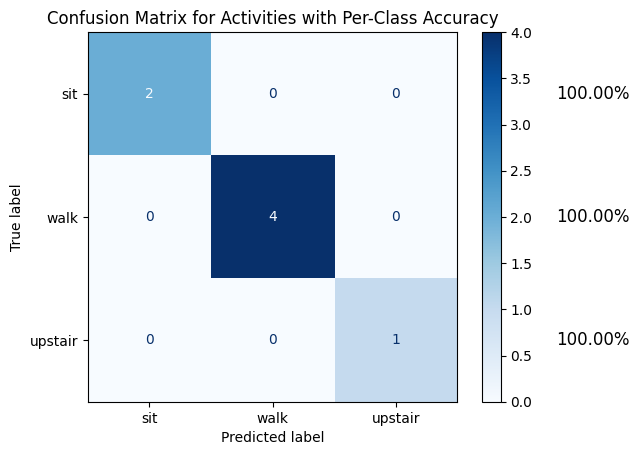

In [70]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
chunk_sizes = [
    0.25, 0.5, 1.0, 1.375, 2.75, 5.5
]
# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

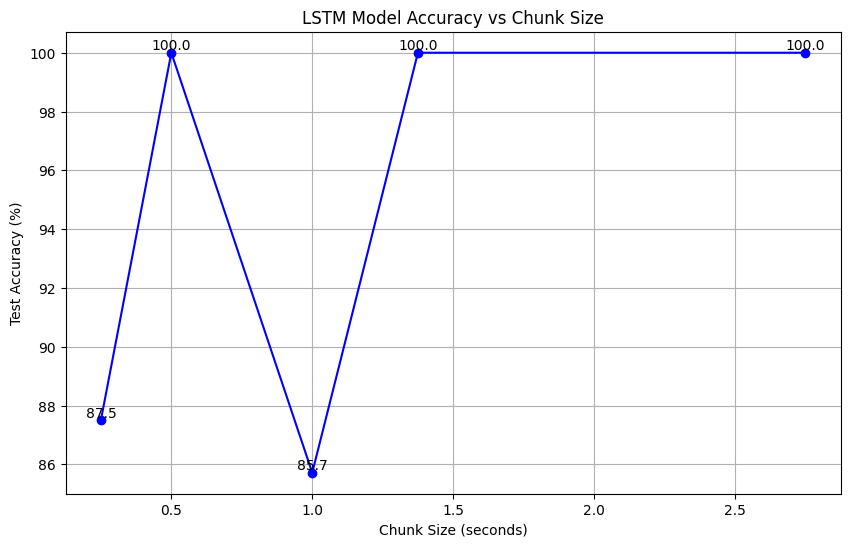


LSTM Results Summary:
 Chunk Size (s)  Accuracy (%)
          0.250     87.500000
          0.500    100.000000
          1.000     85.714286
          1.375    100.000000
          2.750    100.000000


In [71]:
min_length = min(len(chunk_sizes), len(fold_accuracies))
chunk_sizes = chunk_sizes[:min_length]
fold_accuracies = fold_accuracies[:min_length]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chunk_sizes, fold_accuracies, 'bo-')
plt.xlabel('Chunk Size (seconds)')
plt.ylabel('Test Accuracy (%)')
plt.title('LSTM Model Accuracy vs Chunk Size')
plt.grid(True)

# Add accuracy values as text
for x, y in zip(chunk_sizes, fold_accuracies):
    plt.text(x, y, f'{y:.1f}', ha='center', va='bottom')

plt.savefig('lstm_chunk_size_vs_accuracy.png')
plt.show()

# Print results table
results = pd.DataFrame({
    'Chunk Size (s)': chunk_sizes,
    'Accuracy (%)': fold_accuracies
})
print("\nLSTM Results Summary:")
print(results.to_string(index=False))

In [72]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")